In [ ]:
!pip install nltk transformers

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Activation
from tensorflow.keras.models import Sequential

import transformers

import nltk

In [ ]:
nltk.download('all')

In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-39e6412f-b0e4-e371-bac5-5a682b136cc2)


# PubMed abstracts

In [5]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 10.34 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [6]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign
!ls pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [7]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [8]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

In [9]:
# visualize
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines as a list

  Args:
    filename (str): target file path
  
  Returns:
    a list of strings with one string per line fron the target filename
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [10]:
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [11]:
len(train_lines)

210040

In [12]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data

  Takes in the filename, reads its content and sorts through each line,
  extracting things like the target label, text in the sentence, 
  total number of sentences in current abstract and sentence number of target line
  """
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  # loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""

    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      # iterate through each line
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples    

In [13]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 640 ms, sys: 135 ms, total: 776 ms
Wall time: 900 ms


(180040, 30212, 30135)

In [14]:
train_samples[:11]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [15]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [16]:
# distribution of labels
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

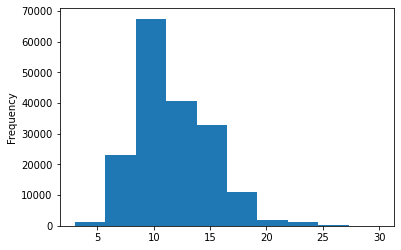

In [17]:
# length of lines
train_df.total_lines.plot.hist()

<AxesSubplot:xlabel='total_lines', ylabel='Count'>

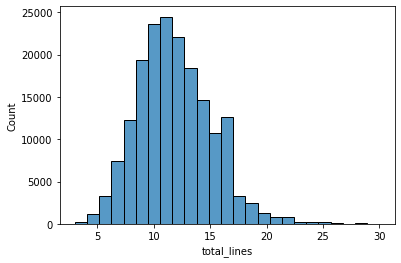

In [18]:
sns.histplot(train_df.total_lines, bins=25)

### get a list of sentences

In [19]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist() 

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

### make numeric labels

In [20]:
import sklearn
print(sklearn.__version__)

1.2.2


In [21]:
# one hot encoded labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False) # to turn into tensors

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [22]:
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### LabelEncode labels

In [23]:
# extract labels to integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [24]:
# get class names
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(num_classes, class_names)

5 ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


# baseline model

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

baseline_model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

baseline_model.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
baseline_model.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [27]:
baseline_preds = baseline_model.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [28]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [29]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-15 15:19:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-15 15:19:42 (81.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



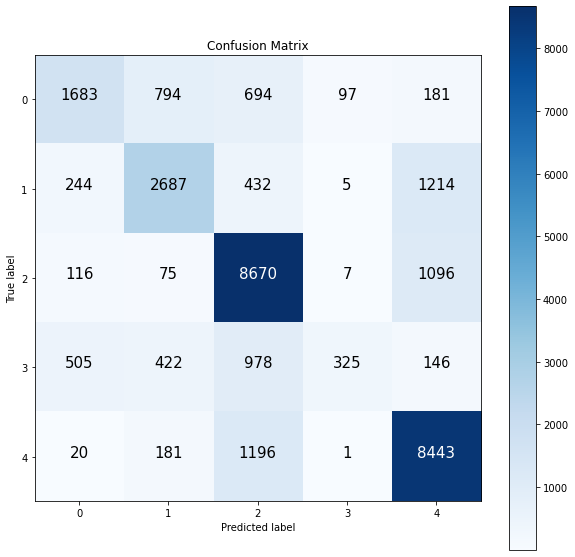

In [30]:
from helper_functions import make_confusion_matrix, plot_loss_curves, calculate_results
make_confusion_matrix(y_true=val_labels_encoded, y_pred=baseline_preds)

In [31]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                  y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# model_1 Conv1D

## preparing the data for deep models

* vectorization and embeddings

In [32]:
# average sentece lenght
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

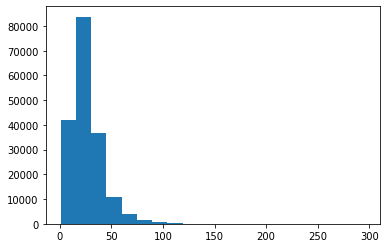

In [33]:
# distribution
plt.hist(sent_lens, bins=20)

In [34]:
# how long of a sentence lenght cover 95 percent of senttences?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [35]:
# max sentence lenght
max(sent_lens)

296

### text vectorizer layer

In [36]:
from tensorflow.keras.layers import TextVectorization

MAX_TOKENS = 68000 # from PubMed paper

text_vectorizer = TextVectorization(max_tokens=MAX_TOKENS,
                                    output_sequence_length=output_seq_len)

In [37]:
# adapt to train data
text_vectorizer.adapt(train_sentences)

In [38]:
import random

target_sentence = random.choice(train_sentences)
print('Text: \n{}'.format(target_sentence))
print(f'Length: {len(target_sentence)}')
print(f'Vectorized version: \n{text_vectorizer(target_sentence)}')

Text: 
these findings show that the integration of c into a neoadjuvant taxane - / anthracycline-based regimen is a feasible , safe , and effective treatment option , with incorporation of trastuzumab in her@-positive disease .
Length: 220
Vectorized version: 
[  111   310   812    28     2  3218     4   243   143     8  2397  8559
 23891   576    20     8  1099   514     3   137    19  1177     7  7505
     4  2466     5  5013   114     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]


In [39]:
rct_20k_text_vocabulary = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocabulary)}')
print(f'Most common words: {rct_20k_text_vocabulary[:5]}')
print(f'Least common words: {rct_20k_text_vocabulary[-5:]}')

Number of words in vocab: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [40]:
# get the config of text_vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8'}

### embedding layer

In [41]:
from tensorflow.keras.layers import Embedding

token_embed = Embedding(input_dim=len(rct_20k_text_vocabulary),
                        output_dim=128,
                        mask_zero=True,     # efficient computing
                        name='token_embedding') 

In [42]:
print(f'Sentence: \n{target_sentence}')
vecetorized_sentence = text_vectorizer([target_sentence])
print(f'Text vectorization: \n{vecetorized_sentence}')
print(f'Text vectorization shape: {vecetorized_sentence.shape}')
embedded_sentence = token_embed(vecetorized_sentence)
print(f'Token Embedded sentence: \n{embedded_sentence}')
print(f'Token Embedded sentence shape: {embedded_sentence.shape}')

Sentence: 
these findings show that the integration of c into a neoadjuvant taxane - / anthracycline-based regimen is a feasible , safe , and effective treatment option , with incorporation of trastuzumab in her@-positive disease .
Text vectorization: 
[[  111   310   812    28     2  3218     4   243   143     8  2397  8559
  23891   576    20     8  1099   514     3   137    19  1177     7  7505
      4  2466     5  5013   114     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Text vectorization shape: (1, 55)
Token Embedded sentence: 
[[[ 0.009337    0.03536378  0.03837739 ...  0.02281928  0.01910246
    0.01288353]
  [-0.04980855 -0.04075426 -0.00389606 ...  0.02244992 -0.0121847
   -0.04894597]
  [-0.03397993 -0.01611545 -0.04313239 ... -0.04312873  0.02722773
   -0.0354305 ]
  ...
  [-0.02736235 -0.00442988  0.0237695  ...  0.01702905  0.01274761
   -0.01264947]
  [-0.02

# create tensorflow dateset pipeline

In [43]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset, train_labels_one_hot.shape

(<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 (180040, 5))

In [44]:
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [45]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D
from tensorflow.keras.layers import GlobalAveragePooling1D

inputs = Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = GlobalAveragePooling1D()(x)
outputs = Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss=losses.CategoricalCrossentropy(),
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [46]:
len(train_dataset), len(val_dataset), int(.1 * len(train_dataset))

(5627, 945, 562)

In [47]:
from helper_functions import create_tensorboard_callback

history_conv1d = model_1.fit(train_dataset,
                             epochs=3,
                             steps_per_epoch=int(.1 * len(train_dataset)),
                             validation_data=val_dataset,
                             validation_steps=int(.1 * len(val_dataset)),
                             callbacks=[create_tensorboard_callback(dir_name='logs/fit',
                                                                    experiment_name='model_1_conv1d')])

Saving TensorBoard log files to: logs/fit/model_1_conv1d/20230315-152009
Epoch 1/3
562/562 [==============================] - 42s 55ms/step - loss: 0.9258 - accuracy: 0.6324 - val_loss: 0.6967 - val_accuracy: 0.7307
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.6688 - accuracy: 0.7520 - val_loss: 0.6451 - val_accuracy: 0.7633
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6269 - accuracy: 0.7707 - val_loss: 0.6028 - val_accuracy: 0.7809


In [48]:
results_conv1d = model_1.evaluate(val_dataset)
results_conv1d

945/945 [==============================] - 5s 5ms/step - loss: 0.6051 - accuracy: 0.7837


[0.6050757169723511, 0.7836952209472656]

In [49]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs[:10], model_1_pred_probs.shape, 

945/945 [==============================] - 3s 3ms/step


(array([[4.0533677e-01, 1.9794579e-01, 6.5345913e-02, 3.0448961e-01,
         2.6881890e-02],
        [4.2672130e-01, 3.1407437e-01, 1.0052586e-02, 2.4055225e-01,
         8.5994955e-03],
        [1.6260064e-01, 8.1098750e-03, 2.1357853e-03, 8.2711095e-01,
         4.2758638e-05],
        [1.3787947e-05, 3.2120018e-04, 9.8128831e-01, 1.6028778e-05,
         1.8360602e-02],
        [8.9151517e-04, 3.7463829e-02, 2.8338990e-01, 9.2167949e-04,
         6.7733312e-01],
        [2.1262191e-02, 3.6577467e-02, 5.5220139e-01, 1.0063226e-02,
         3.7989566e-01],
        [4.0520151e-04, 5.3467448e-03, 2.7439725e-01, 2.4949043e-04,
         7.1960127e-01],
        [2.7822057e-02, 2.8346319e-02, 6.4930463e-01, 1.6728925e-02,
         2.7779809e-01],
        [8.8163621e-14, 4.8334531e-08, 1.7812211e-07, 1.1887088e-13,
         9.9999976e-01],
        [1.0677813e-02, 6.6587228e-01, 4.9030870e-02, 2.4973350e-02,
         2.4944565e-01]], dtype=float32), (30212, 5))

In [50]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:10], model_1_preds.shape

(<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 4, 2, 4, 2, 4, 1])>,
 TensorShape([30212]))

In [51]:
results_conv1d = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_1_preds)
results_conv1d, baseline_results

({'accuracy': 78.36952204422084,
  'precision': 0.7803364606076001,
  'recall': 0.7836952204422084,
  'f1': 0.7812442135566685},
 {'accuracy': 72.1832384482987,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869,
  'f1': 0.6989250353450294})

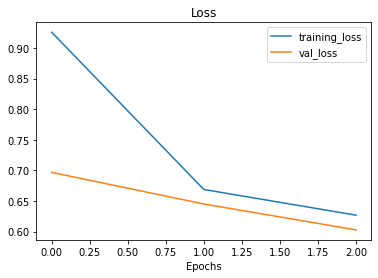

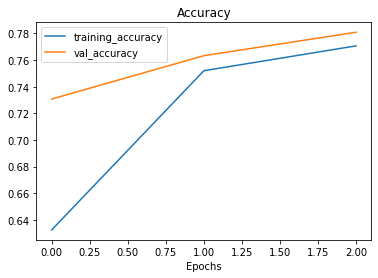

In [52]:
plot_loss_curves(history_conv1d)

# model_2 pretrained feature extraction with pretrained token embeddings from tf hub

In [53]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [54]:
random_train_sentence = random.choice(train_sentences)
print(f'Random sentence: \n{random_train_sentence}')
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f'Embedded sentence: \n{use_embedded_sentence[0][:30]}')
print(f'Length of USE embedded sentence: {len(use_embedded_sentence[[0]])}')

Random sentence: 
these results support the implementation of two-dose varicella vaccination on a short course , to ensure optimum protection from all forms of varicella disease .
Embedded sentence: 
[ 0.05108802 -0.0308612  -0.01022454  0.02857272 -0.01882361 -0.01491598
  0.0218863   0.0508309  -0.0334039   0.00658927  0.09167034  0.00034244
  0.00223905  0.03215614  0.05133775  0.04839913 -0.09291103 -0.03251891
 -0.06168986 -0.02769588 -0.06962892 -0.0141662  -0.03675793  0.03948718
  0.06568753  0.07287852 -0.01358533  0.01825352  0.00740866  0.0702705 ]
Length of USE embedded sentence: 512


In [55]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) 
x = layers.Dense(128, activation="relu")(pretrained_embedding) 
outputs = layers.Dense(5, activation="softmax")(x) 
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])    

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [56]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [57]:
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=val_dataset,
            validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 16ms/step - loss: 0.9210 - accuracy: 0.6469 - val_loss: 0.7962 - val_accuracy: 0.6882
Epoch 2/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7690 - accuracy: 0.7015 - val_loss: 0.7541 - val_accuracy: 0.7055
Epoch 3/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7529 - accuracy: 0.7118 - val_loss: 0.7387 - val_accuracy: 0.7121


In [58]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 14s 15ms/step - loss: 0.7400 - accuracy: 0.7127


[0.7400016188621521, 0.7127300500869751]

In [59]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

945/945 [==============================] - 13s 14ms/step


array([[0.44866952, 0.3635617 , 0.00254227, 0.17773268, 0.00749382],
       [0.34861353, 0.4959958 , 0.00467612, 0.14716479, 0.00354974],
       [0.2371469 , 0.16292089, 0.01986086, 0.5448629 , 0.03520838],
       ...,
       [0.00201142, 0.00604439, 0.06991626, 0.00106973, 0.92095816],
       [0.00429804, 0.04752661, 0.22909968, 0.00177114, 0.7173046 ],
       [0.1923088 , 0.24624553, 0.50116956, 0.00770684, 0.05256927]],
      dtype=float32)

In [60]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [61]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.2730041043294,
 'precision': 0.7125063133134099,
 'recall': 0.7127300410432941,
 'f1': 0.7097068496990778}

# Model 3: Conv1D with character embeddings

## Creating a character-level tokenizer

In [62]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_train_sentence)

't h e s e   r e s u l t s   s u p p o r t   t h e   i m p l e m e n t a t i o n   o f   t w o - d o s e   v a r i c e l l a   v a c c i n a t i o n   o n   a   s h o r t   c o u r s e   ,   t o   e n s u r e   o p t i m u m   p r o t e c t i o n   f r o m   a l l   f o r m s   o f   v a r i c e l l a   d i s e a s e   .'

In [63]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [64]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

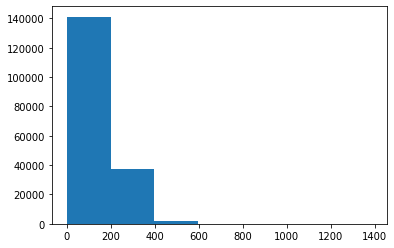

In [65]:
plt.hist(char_lens, bins=7);

In [66]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [67]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [68]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [69]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [70]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
p a t i e n t s   w i t h   h i s t o l o g i c a l l y   c o n f i r m e d   r e s e c t a b l e   s t a g e   t @   o r   t @   r e c t a l   a d e n o c a r c i n o m a   w e r e   e l i g i b l e   w i t h   a n   a g e   l i m i t   o f   @   y e a r s   .

Length of chars: 111

Vectorized chars:
[[14  5  3  4  2  6  3  9 20  4  3 13 13  4  9  3  7 12  7 18  4 11  5 12
  12 19 11  7  6 17  4  8 15  2 10  8  2  9  2 11  3  5 22 12  2  9  3  5
  18  2  3  7  8  3  8  2 11  3  5 12  5 10  2  6  7 11  5  8 11  4  6  7
  15  5 20  2  8  2  2 12  4 18  4 22 12  2 20  4  3 13  5  6  5 18  2 12
   4 15  4  3  7 17 19  2  5  8  9  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  

## character-level Embedding

In [71]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25,    # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=True,   
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
p a t i e n t s   w i t h   h i s t o l o g i c a l l y   c o n f i r m e d   r e s e c t a b l e   s t a g e   t @   o r   t @   r e c t a l   a d e n o c a r c i n o m a   w e r e   e l i g i b l e   w i t h   a n   a g e   l i m i t   o f   @   y e a r s   .

Embedded chars (after vectorization and embedding):
[[[ 0.04342848  0.02743188 -0.00573153 ... -0.0163342  -0.03714306
    0.03409005]
  [-0.00899244  0.02890806 -0.04666232 ... -0.01883331 -0.02634602
   -0.04417448]
  [-0.04723455  0.02075965 -0.01480272 ...  0.01283332  0.0434902
    0.0392873 ]
  ...
  [ 0.00689696  0.03426483 -0.03703469 ...  0.03432396  0.01395075
   -0.04021933]
  [ 0.00689696  0.03426483 -0.03703469 ...  0.03432396  0.01395075
   -0.04021933]
  [ 0.00689696  0.03426483 -0.03703469 ...  0.03432396  0.01395075
   -0.04021933]]]

Character embedding shape: (1, 290, 25)


## Building a Conv1D model to fit on character embeddings

In [72]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [73]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

In [74]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [75]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 7s 10ms/step - loss: 1.2534 - accuracy: 0.4893 - val_loss: 1.0403 - val_accuracy: 0.5914
Epoch 2/3
562/562 [==============================] - 4s 8ms/step - loss: 0.9971 - accuracy: 0.6009 - val_loss: 0.9280 - val_accuracy: 0.6430
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9139 - accuracy: 0.6428 - val_loss: 0.8520 - val_accuracy: 0.6759


In [76]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.8729 - accuracy: 0.6640


[0.8728667497634888, 0.6639745831489563]

In [77]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 4s 4ms/step


array([[0.20626055, 0.40710518, 0.15956372, 0.16899331, 0.05807719],
       [0.18607281, 0.49127585, 0.00813807, 0.308078  , 0.00643528],
       [0.12748745, 0.19485708, 0.0671335 , 0.5986041 , 0.01191781],
       ...,
       [0.01723829, 0.06161607, 0.07039379, 0.02128569, 0.8294661 ],
       [0.03291098, 0.10076381, 0.3547271 , 0.05051406, 0.46108398],
       [0.3231239 , 0.44215328, 0.16472398, 0.05822293, 0.01177602]],
      dtype=float32)

In [78]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [79]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 66.39745796372303,
 'precision': 0.6607102980656441,
 'recall': 0.6639745796372303,
 'f1': 0.6545891701570269}

# Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

In [80]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [81]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

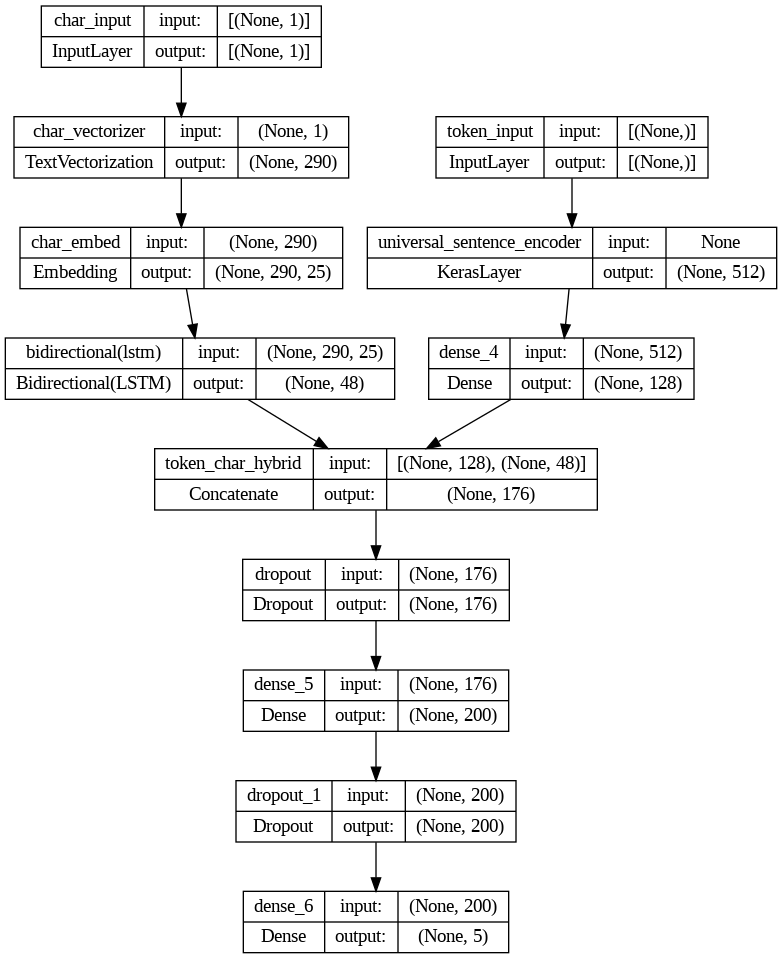

In [82]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [83]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [84]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps test data
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [85]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [86]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 49s 65ms/step - loss: 0.9688 - accuracy: 0.6152 - val_loss: 0.7682 - val_accuracy: 0.7068
Epoch 2/3
562/562 [==============================] - 33s 59ms/step - loss: 0.7868 - accuracy: 0.6993 - val_loss: 0.7053 - val_accuracy: 0.7307
Epoch 3/3
562/562 [==============================] - 31s 55ms/step - loss: 0.7678 - accuracy: 0.7061 - val_loss: 0.6865 - val_accuracy: 0.7407


In [87]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 26s 24ms/step


array([[4.3872473e-01, 3.5077286e-01, 4.7084671e-03, 1.9508919e-01,
        1.0704732e-02],
       [3.7762669e-01, 4.0290833e-01, 4.3528397e-03, 2.1281497e-01,
        2.2972398e-03],
       [3.2940611e-01, 1.0251208e-01, 5.2296836e-02, 4.8229039e-01,
        3.3494547e-02],
       ...,
       [1.3272598e-03, 1.6034801e-02, 6.6230878e-02, 3.8729960e-04,
        9.1601980e-01],
       [6.4294855e-03, 5.8678750e-02, 2.1468791e-01, 3.4638855e-03,
        7.1673995e-01],
       [2.1573246e-01, 5.3507632e-01, 1.9296472e-01, 1.3051104e-02,
        4.3175381e-02]], dtype=float32)

In [88]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [89]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.6296835694426,
 'precision': 0.7360357713807024,
 'recall': 0.736296835694426,
 'f1': 0.7339376996228405}

# Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [90]:
# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


## Create positional embeddings

In [91]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<AxesSubplot:ylabel='Frequency'>

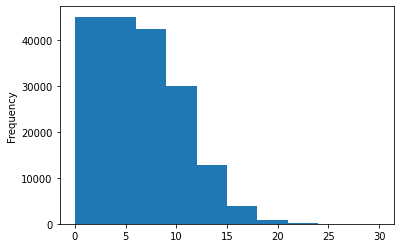

In [92]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [93]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [94]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

In [95]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<AxesSubplot:ylabel='Frequency'>

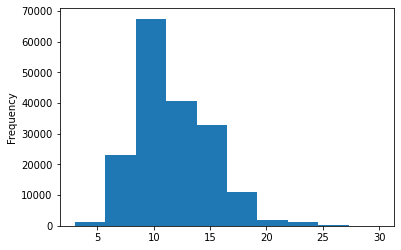

In [96]:
# Check the distribution of total lines
train_df.total_lines.plot.hist()

In [97]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [98]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

## Building a tribrid embedding model

In [99]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer,
                         name='tribrid_embedding')

In [100]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "tribrid_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0]

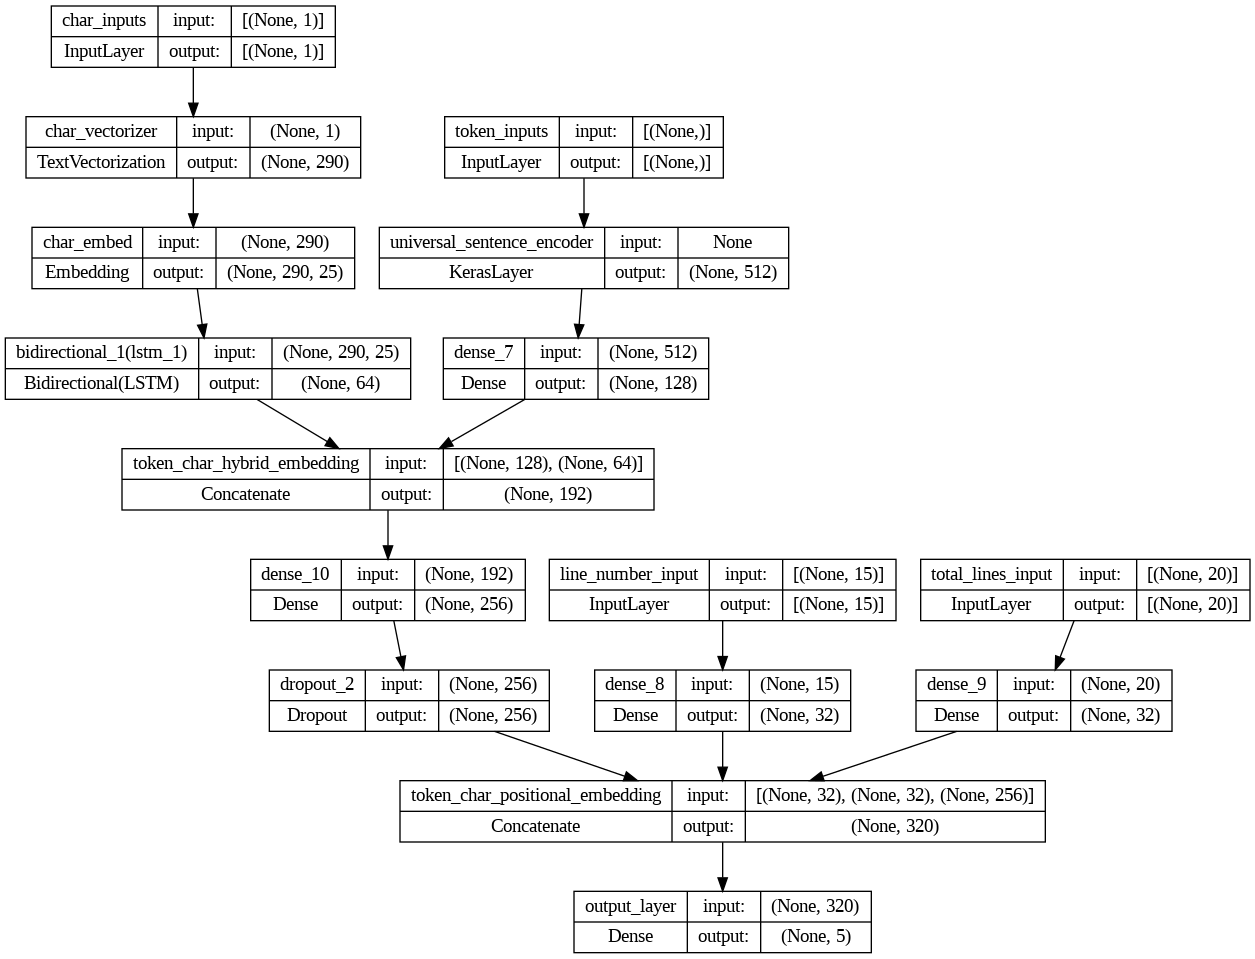

In [101]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [102]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fd84fa265b0> True
<keras.engine.input_layer.InputLayer object at 0x7fd84fa22640> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7fd8442d81c0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7fd8ecc2e0d0> False
<keras.layers.core.embedding.Embedding object at 0x7fd83b0f3160> True
<keras.layers.core.dense.Dense object at 0x7fd84fa26430> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x7fd84f98a910> True
<keras.layers.merging.concatenate.Concatenate object at 0x7fd84e18bdc0> True
<keras.engine.input_layer.InputLayer object at 0x7fd84f99bdc0> True
<keras.engine.input_layer.InputLayer object at 0x7fd84f9c2be0> True
<keras.layers.core.dense.Dense object at 0x7fd84f9a1130> True
<keras.layers.core.dense.Dense object at 0x7fd84f932e20> True
<keras.layers.core.dense.Dense object at 0x7fd84e1a20a0> True
<keras.layers.regularization.dropout.Dropout object at 0x7fd84e229940> True
<keras.layers

In [103]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

## Create tribrid embedding datasets and fit tribrid model

In [104]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Test dataset
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [105]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 49s 65ms/step - loss: 1.0924 - accuracy: 0.7268 - val_loss: 0.9822 - val_accuracy: 0.8022
Epoch 2/3
562/562 [==============================] - 42s 74ms/step - loss: 0.9680 - accuracy: 0.8141 - val_loss: 0.9510 - val_accuracy: 0.8311
Epoch 3/3
562/562 [==============================] - 29s 52ms/step - loss: 0.9515 - accuracy: 0.8244 - val_loss: 0.9363 - val_accuracy: 0.8314


In [106]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 27s 24ms/step


array([[0.52168405, 0.10897956, 0.01169613, 0.34093615, 0.01670413],
       [0.5535406 , 0.09999278, 0.05528661, 0.28020626, 0.01097377],
       [0.3059876 , 0.11278637, 0.13412099, 0.3782333 , 0.06887166],
       ...,
       [0.03698177, 0.11109913, 0.04221002, 0.0312074 , 0.7785017 ],
       [0.03459436, 0.26911452, 0.06700708, 0.02873906, 0.600545  ],
       [0.19564998, 0.58107233, 0.11980717, 0.03504628, 0.06842422]],
      dtype=float32)

In [107]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [108]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.43373493975903,
 'precision': 0.8338489499289152,
 'recall': 0.8343373493975904,
 'f1': 0.8327776398006377}

# Compare model results

In [109]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": results_conv1d,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.369522,0.780336,0.783695,0.781244
pretrained_token_embed,71.273004,0.712506,0.712730,0.709707
custom_char_embed_conv1d,66.397458,0.660710,0.663975,0.654589
hybrid_char_token_embed,73.629684,0.736036,0.736297,0.733938
tribrid_pos_char_token_embed,83.433735,0.833849,0.834337,0.832778


In [110]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

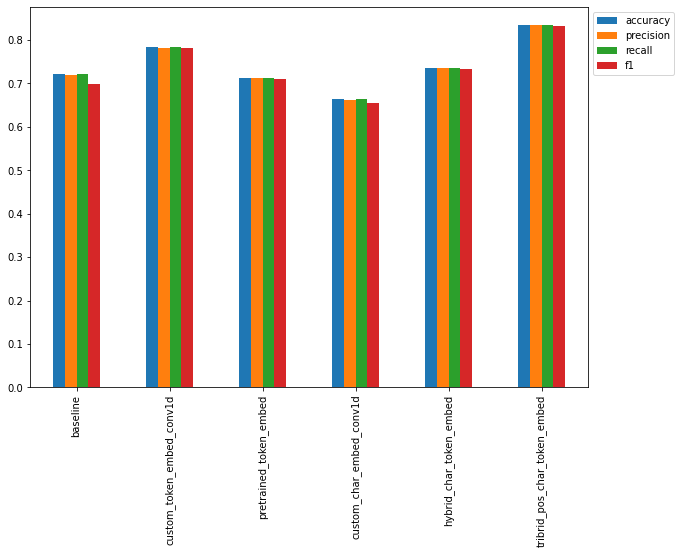

In [111]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

<AxesSubplot:>

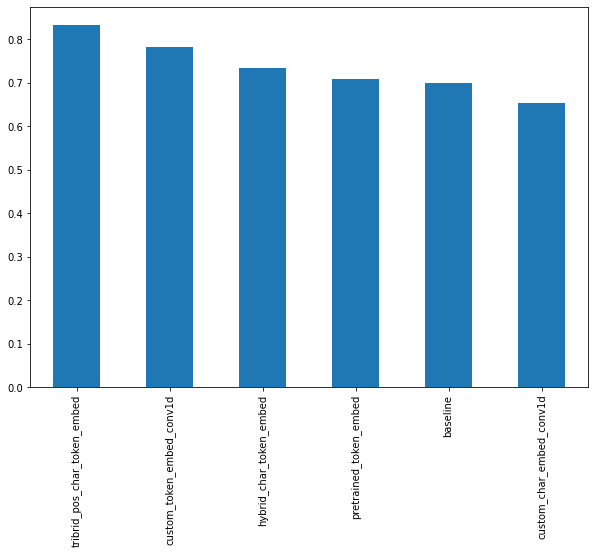

In [112]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

# Save and load best performing model

In [113]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string

In [114]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [115]:
# Copying saved model from Google Colab to Drive (requires Google Drive to be mounted)
!mkdir /content/drive/MyDrive/models/
!cp /content/skimlit_tribrid_model -r /content/drive/MyDrive/models/skim_lit

In [116]:
model_path = "/content/drive/MyDrive/models/skim_lit"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)

# Make predictions and evalaute them against the truth labels

In [117]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 29s 27ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [118]:
# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 83.43373493975903,
 'precision': 0.8338489499289152,
 'recall': 0.8343373493975904,
 'f1': 0.8327776398006377}

In [119]:
assert loaded_model_results == model_5_results

In [120]:
# Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

array([ True,  True,  True,  True])

In [121]:
# Check loaded model summary (note the number of trainable parameters)
loaded_model.summary()

Model: "tribrid_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0]

# Evaluate model on test dataset

In [122]:
# Check shapes
test_pos_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [123]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 24s 25ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 1, 0])>

In [124]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 83.18234610917537,
 'precision': 0.8306458235104316,
 'recall': 0.8318234610917538,
 'f1': 0.8303076792912357}

# Find most wrong

In [125]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes[:10]

CPU times: user 17.6 s, sys: 818 ms, total: 18.5 s
Wall time: 17.5 s


['OBJECTIVE',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND']

In [126]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.440749,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.364153,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.778790,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.648554,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.735006,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.885701,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.531516,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.547127,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.451129,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.596855,True


In [127]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.948844,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.947880,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.930374,False
16633,CONCLUSIONS,clinicaltrials.gov identifier : nct@ .,19,19,BACKGROUND,0.915356,False
29294,RESULTS,"baseline measures included sociodemographics ,...",4,13,METHODS,0.915094,False
...,...,...,...,...,...,...,...
19481,METHODS,nct@ .,5,8,BACKGROUND,0.843708,False
24785,BACKGROUND,to test the hypothesis that this electronic ac...,2,13,OBJECTIVE,0.843299,False
23202,RESULTS,the prebious trial has the potential to demons...,6,6,CONCLUSIONS,0.842927,False
705,RESULTS,the bi requires further testing in a randomise...,12,14,CONCLUSIONS,0.841713,False


In [128]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9488437175750732, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9478803873062134, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9303739666938782, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9153556823730469, Line number: 19, Total lines: 19

Text:
clinicaltrials.gov identifier : nct@ .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9150944948196411, Line number: 4, Total lines: 13

Text:
baseline measures included sociodemographics , standardized anthropometrics , asthma control test ( act ) , gerd symptom assessment scale , pittsburgh sleep quality index , and berli

# Make example predictions

In [129]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2023-03-15 15:32:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-03-15 15:32:30 (72.0 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [130]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [131]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd 
from spacy.lang.en import English
nlp = English() # setup English sentence parser
nlp.add_pipe('sentencizer') # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[0]["abstract"]) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [132]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [133]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]

# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [134]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]

# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [135]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [136]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 4s 4s/step
CPU times: user 3.55 s, sys: 76.2 ms, total: 3.62 s
Wall time: 3.66 s


array([[0.30733225, 0.09538875, 0.0186694 , 0.5479011 , 0.03070848],
       [0.08950514, 0.01999889, 0.7117293 , 0.10902036, 0.06974629],
       [0.11070696, 0.04702264, 0.6023412 , 0.15853544, 0.08139378],
       [0.11399201, 0.14192022, 0.5391239 , 0.08415924, 0.12080457],
       [0.0611185 , 0.08873674, 0.4540912 , 0.0501595 , 0.3458941 ],
       [0.03540257, 0.10269129, 0.577413  , 0.0433161 , 0.24117696],
       [0.03674947, 0.12219808, 0.07221494, 0.02893402, 0.7399035 ],
       [0.01990521, 0.08866513, 0.22468722, 0.03285683, 0.63388556]],
      dtype=float32)

In [137]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [138]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [139]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


# Train model_5 on all of the data in the training dataset for as many epochs until it stops improving.

In [140]:
import tensorflow as tf
from tensorflow.keras import layers 

In [175]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

In [147]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [148]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [149]:
# Create function to read the lines of a document
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [150]:
# Creating a preprocessing function that returns a dictionary
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
      
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [151]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") 
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

len(train_samples), len(val_samples), len(test_samples)

CPU times: user 483 ms, sys: 117 ms, total: 600 ms
Wall time: 684 ms


(180040, 30212, 30135)

In [152]:
# Loading our data into a dataframe
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [153]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [154]:
# One hot encoding the labels 
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [155]:
# Extract labels and encoder them into integers 
from sklearn.preprocessing import LabelEncoder 

label_encoder = LabelEncoder() 

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [156]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes , class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Prepare for deep learning models

In [157]:
from tensorflow.keras.layers import TextVectorization

MAX_TOKENS = 68000 # from PubMed paper

text_vectorizer = TextVectorization(max_tokens=MAX_TOKENS,
                                    output_sequence_length=output_seq_len)

In [158]:
# adapt to train data
text_vectorizer.adapt(train_sentences)

In [159]:
from tensorflow.keras.layers import Embedding

token_embed = Embedding(input_dim=len(rct_20k_text_vocabulary),
                        output_dim=128,
                        mask_zero=True,     # efficient computing
                        name='token_embedding') 

In [160]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [161]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

## Train model_6 which is like model_5 on all data

In [215]:
# Creating the callbacks 
check_filepath = 'best_weights/checkpoint.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= check_filepath , 
                                                               save_weights_only = True , 
                                                               save_best_only = True  , 
                                                               save_freq = 'epoch' , 
                                                               monitor = 'val_loss')

early_stopping  = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss' , 
                                                   patience = 3, min_delta = 0.5 , verbose = 1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, 
                                                 patience=2,
                                                 verbose=1, 
                                                 min_lr=1e-7)

In [165]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_6 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer,
                         name='tribrid_embedding')

In [166]:
# Compile token, char, positional embedding model
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

## fit the model

In [216]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Test dataset
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [218]:
# Fit the token, char and positional embedding model
history_model_6 = model_6.fit(train_pos_char_token_dataset,
                              steps_per_epoch=len(train_pos_char_token_dataset),
                              epochs=100,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=len(val_pos_char_token_dataset),
                              callbacks=[model_checkpoint_callback,
                                         early_stopping,
                                         reduce_lr])

Epoch 1/100
5627/5627 [==============================] - 321s 57ms/step - loss: 0.8856 - accuracy: 0.8704 - val_loss: 0.8939 - val_accuracy: 0.8585 - lr: 0.0010
Epoch 2/100
5627/5627 [==============================] - 313s 56ms/step - loss: 0.8791 - accuracy: 0.8761 - val_loss: 0.8943 - val_accuracy: 0.8565 - lr: 0.0010
Epoch 3/100
5627/5627 [==============================] - 330s 59ms/step - loss: 0.8735 - accuracy: 0.8797 - val_loss: 0.8933 - val_accuracy: 0.8603 - lr: 0.0010
Epoch 4/100
5627/5627 [==============================] - 325s 58ms/step - loss: 0.8684 - accuracy: 0.8834 - val_loss: 0.8966 - val_accuracy: 0.8573 - lr: 0.0010
Epoch 4: early stopping


In [219]:
# Make predictions with token-char-positional hybrid model
model_6_pred_probs = model_6.predict(val_pos_char_token_dataset, verbose=1)
model_6_pred_probs

945/945 [==============================] - 23s 25ms/step


array([[0.5903458 , 0.08438747, 0.02795424, 0.2614919 , 0.03582061],
       [0.5693786 , 0.09789614, 0.0408703 , 0.2720015 , 0.01985348],
       [0.3009864 , 0.0669681 , 0.01801367, 0.577376  , 0.03665573],
       ...,
       [0.02974671, 0.13262928, 0.05819326, 0.03863475, 0.740796  ],
       [0.01789905, 0.2245041 , 0.04984165, 0.03445579, 0.67329943],
       [0.05075333, 0.861183  , 0.04789091, 0.02674873, 0.01342397]],
      dtype=float32)

In [220]:
# Turn prediction probabilities into prediction classes
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)
model_6_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [221]:
# Calculate results of token-char-positional hybrid model
model_6_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 85.72752548656163,
 'precision': 0.8591175617839856,
 'recall': 0.8572752548656163,
 'f1': 0.854641534897818}

# pretrained GloVe embeddings

In [176]:
# Loading the pre-trained embeddings 
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-03-15 16:00:56--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-03-15 16:00:56--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-03-15 16:00:57--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [184]:
# Getting the path of the glove embedding (using 100D)
import numpy as np 
glove_path = 'glove.6B.100d.txt'

embedding_index = {}

# Making dict of vector representtion of the words (s --> [8, 48......])
with open(glove_path, 'r', encoding="utf-8") as f:
  for line in f:
    
    # Getting the words and coef in a variable 
    word , coefs = line.split(maxsplit = 1)
    coefs = np.fromstring(coefs , 'f' , sep = ' ')
    
    # Adding the coefs to our embedding dict 
    embedding_index[word] = coefs

print(f'Found {len(embedding_index)} word vectors')

Found 400000 word vectors


In [185]:
# Getting the sentences and characters 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()

# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]

In [186]:
# Creatinga a text vectorizaiton layer (68k vocab size from the paper itself)
from tensorflow.keras.layers import TextVectorization 

text_vectorizer = TextVectorization(max_tokens= 68000 , 
                                    output_sequence_length = 56)

# Adapt our text vectorizer to training sentences

text_vectorizer.adapt(train_sentences)

In [187]:
# Getting the vocabulary of the vectorizer 
text_vocab = text_vectorizer.get_vocabulary()
len(text_vocab)

64841

In [188]:
# Getting the dict mapping word --> index 
word_index_text = dict(zip(text_vocab , range(len(text_vocab))))

In [189]:
# Creating a function that will give us a embedding matrix 
def get_glove_embedding_matrix(num_tokens , embedding_dim , word_index):

  # Defining the hits and misses here 
  hits , misses = 0 , 0

  # Prepare the embedding matrix 
  embedding_matrix = np.zeros((num_tokens , embedding_dim ))
  for word , i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector 
      hits += 1 
    else:
      misses += 1 

  return embedding_matrix , hits , misses

In [190]:
# Using the above function to get the embedding matrix 

num_tokens_text = len(text_vocab) + 2 
embedding_dim = 100

sentence_embedding_matrix , hits_ , misses_ = get_glove_embedding_matrix(num_tokens_text , embedding_dim, word_index_text)



print(f'Hits: {hits_} and Misses: {misses_} for the sentence embedding matrix')
     

Hits: 29730 and Misses: 35111 for the sentence embedding matrix


In [191]:
# Adding the embedding matrix to our Embedding layer (Sentence and characters)
from tensorflow.keras.layers import Embedding

sen_embedding_layer = Embedding(num_tokens_text , 
                                embedding_dim , 
                                embeddings_initializer = tf.keras.initializers.Constant(sentence_embedding_matrix) , 
                                trainable = False )

In [192]:
# Creating the datasets for our both sentences and chars  

train_sen_vectors = text_vectorizer(np.array([[sen] for sen in train_sentences])).numpy()
val_sen_vectors = text_vectorizer(np.array([[sen] for sen in val_sentences])).numpy()

# Training and validation dataset 
train_ds = tf.data.Dataset.from_tensor_slices((train_sen_vectors , train_labels_encoded))
val_ds = tf.data.Dataset.from_tensor_slices((val_sen_vectors , val_labels_encoded))


# Applying the batch size and prefetching (performance optimization )
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)


train_ds,  val_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 56), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 56), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [193]:
# Sample 
input = layers.Input(shape = (None,) , dtype = 'int64')
glove_emb = sen_embedding_layer(input)

# sample_emb = embedding_layer(sample_tokens)
x = layers.Conv1D(128 , 5 , activation= 'relu' , padding = 'same')(glove_emb)
x = layers.MaxPooling1D(5, padding = 'same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.MaxPooling1D(5 , padding ='same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names) , activation= 'softmax')(x)

glove_model = tf.keras.Model(input , output)
glove_model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         6484300   
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 128)        0         
 1D)                                                      

In [194]:
# Compiling and fitting the model
glove_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
                     optimizer = tf.keras.optimizers.Adam(), 
                     metrics = ['accuracy'])

glove_model.fit(train_ds,
                 epochs = 3 , 
                 validation_data = val_ds)

Epoch 1/3
5627/5627 [==============================] - 54s 8ms/step - loss: 0.6539 - accuracy: 0.7569 - val_loss: 0.5327 - val_accuracy: 0.8067
Epoch 2/3
5627/5627 [==============================] - 45s 8ms/step - loss: 0.5295 - accuracy: 0.8083 - val_loss: 0.5343 - val_accuracy: 0.8045
Epoch 3/3
5627/5627 [==============================] - 51s 9ms/step - loss: 0.4849 - accuracy: 0.8235 - val_loss: 0.5394 - val_accuracy: 0.8084


# TensorFlow Hub BERT PubMed expert (a language model pretrained on PubMed texts) pretrained embedding

In [ ]:
!pip install tensorflow_text 

In [196]:
# Loading in the both encoder and the preprocessing models 
import tensorflow_text as text
import tensorflow_hub as hub


preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3' ,
                                     trainable = False , 
                                     name = 'pubmed_bert_preprocessor')

bert_layer = hub.KerasLayer('https://tfhub.dev/google/experts/bert/pubmed/2' ,
                            trainable = False , 
                            name = 'bert_model_layer')

In [197]:
# Creating a model out of it 
input = layers.Input(shape = [] , dtype = tf.string , name = 'input_sentences')
bert_inputs = preprocessing_layer(input)
bert_embedding = bert_layer(bert_inputs)
print(f'bert embedding shape: {bert_embedding}')
x = layers.Dense(128 , activation = 'relu')(bert_embedding['pooled_output'])
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names) , activation= 'softmax')(x)

# Packing into a model
pubmed_bert_model = tf.keras.Model(input , output)
pubmed_bert_model.summary()

bert embedding shape: {'default': <KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'bert_model_layer')>, 'pooled_output': <KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'bert_model_layer')>, 'sequence_output': <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, 'encoder_outputs': [<KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTens

In [198]:
# Making datasets for the pubmed model
train_sen_ds = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_encoded))
train_sen_ds = train_sen_ds.batch(32).prefetch(tf.data.AUTOTUNE)

val_sen_ds = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_encoded))
val_sen_ds = val_sen_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [199]:
# Compiling the Pubmed model and fitting it on 10% of the data 
pubmed_bert_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
                          optimizer = tf.keras.optimizers.Adam(), 
                          metrics =['accuracy'])

pubmed_bert_model.fit(train_sen_ds ,
                      steps_per_epoch = int(0.1 * len(train_sen_ds)),
                      epochs = 3 , 
                      validation_data = val_sen_ds , 
                      validation_steps = int(0.1 * len(val_sen_ds)))

Epoch 1/3
562/562 [==============================] - 249s 426ms/step - loss: 0.6478 - accuracy: 0.7764 - val_loss: 0.4671 - val_accuracy: 0.8351
Epoch 2/3
562/562 [==============================] - 242s 430ms/step - loss: 0.5215 - accuracy: 0.8200 - val_loss: 0.4436 - val_accuracy: 0.8281
Epoch 3/3
562/562 [==============================] - 245s 436ms/step - loss: 0.5033 - accuracy: 0.8245 - val_loss: 0.4244 - val_accuracy: 0.8554


# merge our line_number and total_lines features for each sequence

In [200]:
# Combining the total lines and line number into a new feature! 
train_df['line_number_total'] = train_df['line_number'].astype(str) + '_of_' + train_df['total_lines'].astype(str)
val_df['line_number_total'] = val_df['line_number'].astype(str) + '_of_' + val_df['total_lines'].astype(str)

train_df.head(10)

,target,text,line_number,total_lines,line_number_total
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11,0_of_11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11,1_of_11
2,METHODS,outcome measures included pain reduction and i...,2,11,2_of_11
3,METHODS,pain was assessed using the visual analog pain...,3,11,3_of_11
4,METHODS,secondary outcome measures included the wester...,4,11,4_of_11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11,5_of_11
6,RESULTS,there was a clinically relevant reduction in t...,6,11,6_of_11
7,RESULTS,the mean difference between treatment arms ( @...,7,11,7_of_11
8,RESULTS,"further , there was a clinically relevant redu...",8,11,8_of_11
9,RESULTS,these differences remained significant at @ we...,9,11,9_of_11


In [201]:
# Perform one hot encoding on the train and transform the validation dataframe 
from sklearn.preprocessing import OneHotEncoder

# Creating an instance 
one_hot_encoder = OneHotEncoder()

# Fitting on the training dataframe 
one_hot_encoder.fit(np.expand_dims(train_df['line_number_total'] , axis = 1))

# Transforming both train and val df 
train_line_number_total_encoded = one_hot_encoder.transform(np.expand_dims(train_df['line_number_total'] , axis =1))
val_line_number_total_encoded  = one_hot_encoder.transform(np.expand_dims(val_df['line_number_total'] , axis= 1))

# Checking the shapes 
train_line_number_total_encoded.shape , val_line_number_total_encoded.shape

((180040, 460), (30212, 460))

In [202]:
# Converting the sparse object to array 
train_line_number_total_encoded = train_line_number_total_encoded.toarray()
val_line_number_total_encoded = val_line_number_total_encoded.toarray()

# Converting the datatype to int 
train_line_number_total_encoded = tf.cast(train_line_number_total_encoded , dtype= tf.int32)
val_line_number_total_encoded = tf.cast(val_line_number_total_encoded , dtype= tf.int32)

In [203]:
# Making the performant datasets for our tribid model 
train_data = tf.data.Dataset.from_tensor_slices((train_sentences ,
                                                 train_chars , 
                                                 train_line_number_total_encoded))

train_labels = tf.data.Dataset.from_tensor_slices(train_labels_encoded)

val_data = tf.data.Dataset.from_tensor_slices((val_sentences , 
                                               val_chars , 
                                               val_line_number_total_encoded))

val_labels = tf.data.Dataset.from_tensor_slices(val_labels_encoded)

# Zipping the data and labels 
train_dataset = tf.data.Dataset.zip((train_data , train_labels))
val_dataset = tf.data.Dataset.zip((val_data , val_labels))

# Applying batch and prefetching 
train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

train_dataset , val_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [204]:
# Buidling the tribid model using the functional api 

input_token = layers.Input(shape = [] , dtype = tf.string)
bert_inputs_token = preprocessing_layer(input_token)
bert_embedding_char = bert_layer(bert_inputs_token)
output_token = layers.Dense(64 , activation = 'relu')(bert_embedding_char['pooled_output'])
token_model = tf.keras.Model(input_token , output_token)

input_char = layers.Input(shape = [] , dtype = tf.string)
bert_inputs_char = preprocessing_layer(input_char)
bert_embedding_char = bert_layer(bert_inputs_char)
output_char = layers.Dense(64 , activation = 'relu')(bert_embedding_char['pooled_output'])
char_model = tf.keras.Model(input_char , output_char)

line_number_total_input = layers.Input(shape = (460,), dtype = tf.int32)
dense = layers.Dense(32 , activation = 'relu')(line_number_total_input)
total_line_number_model = tf.keras.Model(line_number_total_input , dense)

# Concatenating the tokens amd chars output (Hybrid!!!)
combined_embeddings = layers.Concatenate(name = 'token_char_hybrid_embedding')([token_model.output , 
                                                                                char_model.output])

# Combining the line_number_total to our hybrid model (Time for Tribid!!)
z = layers.Concatenate(name = 'tribid_embeddings')([total_line_number_model.output , 
                                                    combined_embeddings])

# Adding a dense + dropout and creating our output layer 
dropout = layers.Dropout(0.5)(z)
x = layers.Dense(128 , activation='relu')(dropout)
output_layer = layers.Dense(5 , activation='softmax')(x)

# Packing into a model
tribid_model = tf.keras.Model(inputs = [token_model.input , 
                                        char_model.input , 
                                        total_line_number_model.input] , 
                              outputs = output_layer)

tribid_model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 pubmed_bert_preprocessor (Kera  {'input_type_ids':   0          ['input_5[0][0]',                
 sLayer)                        (None, 128),                      'input_6[0][0]']                
                                 'input_mask': (Non                                               
                                e, 128),                                                   

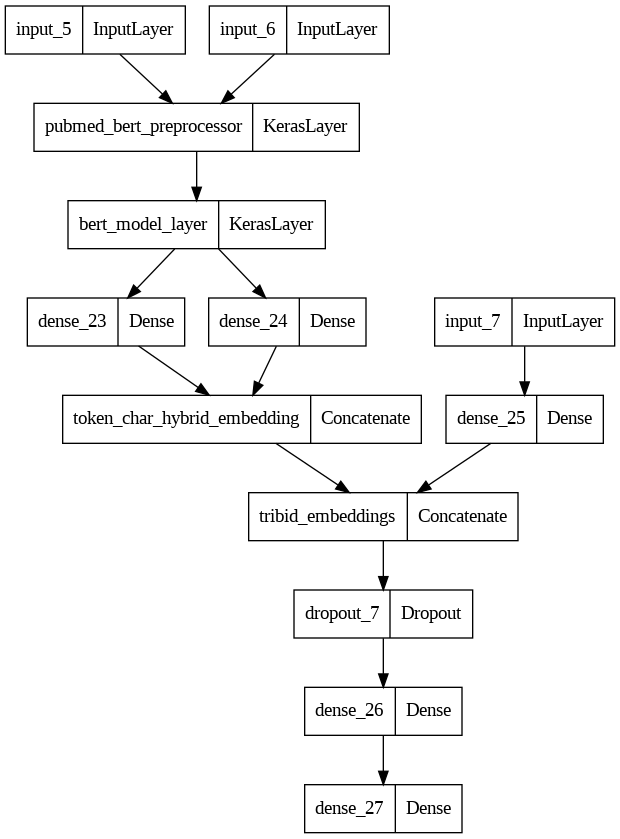

In [207]:
# Plotting the model structure 
from tensorflow.keras.utils import plot_model
plot_model(tribid_model)

In [208]:
# Compiling and fitting the model (Fun Part!)
tribid_model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), 
                     optimizer= tf.keras.optimizers.Adam() , 
                     metrics = ['accuracy'])

# Fitting the model for fewer epochs  (training only on 10% of the data)
# To speed up the experimentation
tribid_model.fit(train_dataset , 
                 steps_per_epoch = int(0.1 * len(train_dataset)), 
                 epochs = 3 , 
                 validation_steps = int(0.1 * len(val_dataset)),
                 validation_data = val_dataset)

Epoch 1/3
281/281 [==============================] - 509s 2s/step - loss: 0.6969 - accuracy: 0.7512 - val_loss: 0.4183 - val_accuracy: 0.8567
Epoch 2/3
281/281 [==============================] - 518s 2s/step - loss: 0.4615 - accuracy: 0.8373 - val_loss: 0.3577 - val_accuracy: 0.8541
Epoch 3/3
281/281 [==============================] - 516s 2s/step - loss: 0.4010 - accuracy: 0.8537 - val_loss: 0.3087 - val_accuracy: 0.8910


In [209]:
# Evaluating on the whole val data 
tribid_model.evaluate(val_dataset)

473/473 [==============================] - 728s 2s/step - loss: 0.3029 - accuracy: 0.8906


[0.30294471979141235, 0.8906064033508301]

#  Take a sample abstract string, preprocess it, make a prediction on each sequence

In [ ]:
# Getting the example abstract to test our function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

In [211]:
# Using json to load in our abstract sample 
import json
with open('skimlit_example_abstracts.json' , 'r') as f:
  example_abstracts = json.load(f)

example_abstracts

[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [212]:
# How does our abstracts look in a DataFrame? 
pd.DataFrame(example_abstracts)

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [213]:
def visualize_pred_sequence_labels(abstract_dict , model , label_encoder):

  '''
  
    Takes in a list of dictionaries of abstracts, 

    [{'abstract': 'This RCT examined .......' , 
      'details': 'RCT of a manuali......',
      'source': 'https://pubmed.ncbi.nlm........./'},..........] 

    Arguments: 
    ----------
      - abstract_dict : Abstract dictionary of the above format 
      - model : the trained model on the same data format (line_numbers,  total_lines , sentences , characters)
      - label_encoder : the label encoder used to encode the classes 

    Returns:
    --------
      Prints out the predicted label and the corresponding sequence/ text 
  '''

  # Setup english sentence parser 
  nlp = English()

  # Create sentence splitting pipeline object 
  nlp.add_pipe('sentencizer')

  # Create doc of parsed sequences
  doc = nlp(abstract_dict[0]['abstract'])

  # Return detected sentences from doc in string typpe 
  abstract_lines = [str(sent) for sent in list(doc.sents)]

  # Get total number of lines 
  total_lines_in_sample = len(abstract_lines)

  # Loop through each line in the abstract and create a list of dictionaries containing features 
  sample_lines = []
  for i , line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict['text'] = str(line)
    sample_dict['line_number'] = i 
    sample_dict['total_lines'] = total_lines_in_sample - 1 
    sample_lines.append(sample_dict)

  
  # Get all line number and total lines numbers then one hot encode them 
  abstract_line_numbers = [line['line_number'] for line in sample_lines]
  abstract_total_lines = [line['total_lines'] for line in sample_lines]

  abstract_line_numbers_one_hot = tf.one_hot(abstract_line_numbers , depth = 15)
  abstract_total_lines_one_hot = tf.one_hot(abstract_total_lines , depth = 20)


  # Split the lines into characters 
  abstract_chars = [split_chars(sentence) for sentence in abstract_lines]

  # Making prediction on sample features
  abstract_pred_probs = model.predict(x = (abstract_line_numbers_one_hot, 
                                           abstract_total_lines_one_hot , 
                                           tf.constant(abstract_lines) , 
                                           tf.constant(abstract_chars)))
  
  # Turn prediction probs to pred class 
  abstract_preds = tf.argmax(abstract_pred_probs , axis = 1)
  
  # Prediction class integers into string class name 
  abstract_pred_classes = [label_encoder.classes_[i] for i in abstract_preds]

  # Prints out the abstract lines and the predicted sequence labels 
  for i , line in enumerate(abstract_lines):
    print(f'{abstract_pred_classes[i]}:  {line}\n')

In [214]:
visualize_pred_sequence_labels(example_abstracts , model_6 , label_encoder)

1/1 [==============================] - 3s 3s/step
OBJECTIVE:  This RCT examined the efficacy of a manualized social intervention for children with HFASDs.

METHODS:  Participants were randomly assigned to treatment or wait-list conditions.

METHODS:  Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.

METHODS:  A response-cost program was applied to reduce problem behaviors and foster skills acquisition.

RESULTS:  Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).

METHODS:  Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.

RESULTS:  High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.

RESULTS:  Standardized effect size estimates were primarily in the medium and large ranges